# Fig 4. Atmos river case study

In [1]:
import os
import sys
import yaml
import argparse
from glob import glob
from datetime import datetime, timedelta

import numpy as np
import xarray as xr

# import torch
# from credit.boundary_padding import TensorPadding

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
%matplotlib inline

sys.path.insert(0, os.path.realpath('../libs/'))
import graph_utils as gu
import verif_utils as vu

In [2]:
import cmaps
# graph tools
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import matplotlib.colorbar as cbar
import matplotlib.ticker as ticker
import matplotlib.lines as mlines

from matplotlib.patches import Rectangle
from matplotlib.ticker import ScalarFormatter
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

import cartopy.crs as ccrs
import cartopy.mpl.geoaxes
import cartopy.feature as cfeature

%matplotlib inline

In [3]:
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 1.0
#mpl.rcParams['hatch.linewidth'] = 1.0

### Load config

In [4]:
config_name = os.path.realpath('plot_config.yml')

with open(config_name, 'r') as stream:
    conf = yaml.safe_load(stream)

### Figure settings

In [5]:
need_publish = False

# True: publication quality figures
# False: low resolution figures in the notebook

if need_publish:
    dpi_ = conf['figure']['keys']['dpi']
else:
    dpi_ = 75

## Data

In [6]:
load_name = '/glade/campaign/cisl/aiml/ksha/CREDIT_cp/VERIF/example_case.npy'
data_PLOT = np.load(load_name, allow_pickle=True)[()]

In [7]:
data_PLOT.keys()

dict_keys(['ERA5_U', 'ERA5_V', 'ERA5_Q', 'IMERG_TP', 'fuxi_mlevel_dry_TP', 'fuxi_mlevel_dry_U', 'fuxi_mlevel_dry_V', 'fuxi_mlevel_dry_Q', 'fuxi_mlevel_physics_TP', 'fuxi_mlevel_physics_U', 'fuxi_mlevel_physics_V', 'fuxi_mlevel_physics_Q', 'fuxi_physics_TP', 'fuxi_physics_U', 'fuxi_physics_V', 'fuxi_physics_Q', 'IFS_TP', 'IFS_U', 'IFS_V', 'IFS_Q', 'latitude', 'longitude', 'time_str'])

In [8]:
latitude = data_PLOT['latitude']
longitude = data_PLOT['longitude']
gridx, gridy = np.meshgrid(longitude, latitude)

In [9]:
ds_static = xr.open_zarr(
    '/glade/derecho/scratch/ksha/CREDIT_data/ERA5_plevel_1deg/static/ERA5_plevel_1deg_6h_subset_static.zarr'
)

In [10]:
elev = ds_static['geopotential_at_surface'].values[30:50, 180:280] / 9.8
elev[elev<1000] = np.nan
elev[elev>=1000] = 1.0

## Plot

In [11]:
grid_shape = gridx.shape
my_colors = gu.ksha_color_set_summon(color_set=0)

red = my_colors['red']
blue = my_colors['blue']
orange = my_colors['orange']

In [12]:
scale_param = '50m'

PROVINCE = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale=scale_param,
    facecolor='none')

def map_gridline_opt(ax):
    '''
    Customize cartopy map gridlines
    '''
    scale_param = '50m'
    # lat/lon gridlines and labeling

    GL = ax.gridlines(crs=ccrs.PlateCarree(), 
                      draw_labels=False, x_inline=False, y_inline=False, 
                      color='k', linewidth=0.1, linestyle=':', zorder=5)
    GL.top_labels = None; GL.bottom_labels = None
    GL.right_labels = None; GL.left_labels = None
    GL.xlabel_style = {'size': 14}; GL.ylabel_style = {'size': 14}
    GL.rotate_labels = False
    #ax.add_feature(cfeature.BORDERS.with_scale(scale_param), linestyle='-', linewidth=2.5, zorder=7)
    #ax.add_feature(PROVINCE, edgecolor='k', linestyle='-', linewidth=2.5, zorder=7)
    ax.add_feature(cfeature.COASTLINE.with_scale(scale_param), edgecolor='0.15', linewidth=1.5, zorder=7)
    ax.spines['geo'].set_linewidth(2.5)
    return ax

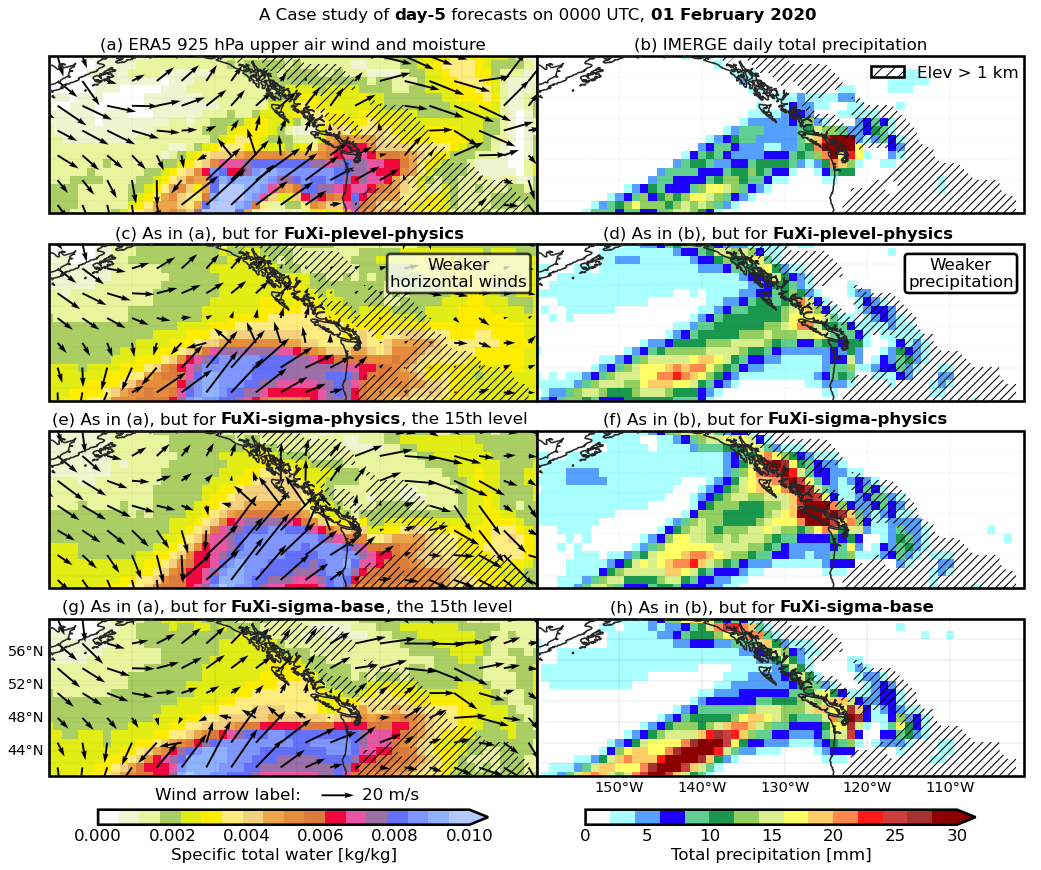

In [13]:
# colormap
CMAP_TP, _ = gu.precip_cmap(return_rgb=True, land_map=False)
CMAP_Q = cmaps.wind_17lev #plt.cm.nipy_spectral_r
edge = [longitude[0]-360+20, longitude[-1]-360-20, latitude[0], latitude[-1]]

handles = []
proj_ = ccrs.PlateCarree(central_longitude=0.0)

fig = plt.figure(figsize=(13, 10), dpi=dpi_)
gs = gridspec.GridSpec(
    4, 2, 
    height_ratios=[1, 1, 1, 1], 
    width_ratios=[1, 1])

AX_maps = []

AX_maps.append(plt.subplot(gs[0, 0], projection=proj_))
AX_maps.append(plt.subplot(gs[0, 1], projection=proj_))
AX_maps.append(plt.subplot(gs[1, 0], projection=proj_))
AX_maps.append(plt.subplot(gs[1, 1], projection=proj_))
AX_maps.append(plt.subplot(gs[2, 0], projection=proj_))
AX_maps.append(plt.subplot(gs[2, 1], projection=proj_))
AX_maps.append(plt.subplot(gs[3, 0], projection=proj_))
AX_maps.append(plt.subplot(gs[3, 1], projection=proj_))

plt.subplots_adjust(0, 0, 1, 1, hspace=0.0, wspace=0.0)
#plt.tight_layout()

for ax in AX_maps:
    ax.set_extent(edge, ccrs.PlateCarree())
    ax = map_gridline_opt(ax)

GL = AX_maps[6].gridlines(
    crs=ccrs.PlateCarree(), 
    draw_labels=True, x_inline=False, y_inline=False, 
    color='k', linewidth=0.1, linestyle=':', zorder=5
)

GL.top_labels = None
GL.bottom_labels = None
GL.right_labels = None
GL.xlabel_style = {'size': 14}; GL.ylabel_style = {'size': 14}
GL.ylocator = ticker.FixedLocator([44, 48, 52, 56])

GL = AX_maps[7].gridlines(
    crs=ccrs.PlateCarree(), 
    draw_labels=True, x_inline=False, y_inline=False, 
    color='k', linewidth=0.1, linestyle=':', zorder=5
)
GL.top_labels = None #GL.bottom_labels = None
GL.right_labels = None
GL.left_labels = None
GL.xlabel_style = {'size': 14}; GL.ylabel_style = {'size': 14}
GL.xlocator = ticker.FixedLocator([-150, -140, -130, -120, -110])

# downsampling arrows
skip = (slice(None, None, 3), slice(None, None, 3))

CS1 = AX_maps[0].pcolormesh(
    gridx, gridy, data_PLOT['ERA5_Q'], 
    cmap=CMAP_Q, transform=ccrs.PlateCarree()
)
AX_maps[0].quiver(
    gridx[skip], gridy[skip], data_PLOT['ERA5_U'][skip], data_PLOT['ERA5_V'][skip], 
    color='k', scale=300, transform=ccrs.PlateCarree()
)
AX_maps[0].contourf(gridx, gridy, elev, colors=('none',), hatches=('///',), zorder=1)

TP_IMERG = 1e3*data_PLOT['IMERG_TP']
CS2 = AX_maps[1].pcolormesh(
    gridx, gridy, TP_IMERG, 
    cmap=CMAP_TP, vmin=0, vmax=60, transform=ccrs.PlateCarree()
)
AX_maps[1].contourf(gridx, gridy, elev, colors=('none',), hatches=('///',), zorder=1)


model_names = ['fuxi_physics', 'fuxi_mlevel_physics', 'fuxi_mlevel_dry']

for i_model, model_name in enumerate(model_names):
    
    ind_panel = i_model+1
    CS1 = AX_maps[2*ind_panel].pcolormesh(
        gridx, gridy, data_PLOT[f'{model_name}_Q'], 
        cmap=CMAP_Q, vmin=0, vmax=0.01, transform=ccrs.PlateCarree()
    )
    if i_model == 2:
        arrow_handle = AX_maps[2*ind_panel].quiver(
            gridx[skip], gridy[skip], data_PLOT[f'{model_name}_U'][skip], data_PLOT[f'{model_name}_V'][skip], 
            color='k', scale=300, transform=ccrs.PlateCarree()
        )
    else:
        AX_maps[2*ind_panel].quiver(
            gridx[skip], gridy[skip], data_PLOT[f'{model_name}_U'][skip], data_PLOT[f'{model_name}_V'][skip], 
            color='k', scale=300, transform=ccrs.PlateCarree()
        )
    AX_maps[2*ind_panel].contourf(gridx, gridy, elev, colors=('none',), hatches=('///',), zorder=1)

    tp_ = 1e3*data_PLOT[f'{model_name}_TP'] # m to mm
    tp_[tp_<0] = 0
    CS2 = AX_maps[2*ind_panel+1].pcolormesh(
        gridx, gridy, tp_, 
        cmap=CMAP_TP, vmin=0, vmax=30, transform=ccrs.PlateCarree()
    )
    AX_maps[2*ind_panel+1].contourf(gridx, gridy, elev, colors=('none',), hatches=('///',), zorder=1)
    
AX_maps[6].quiverkey(
    arrow_handle, X=0.625, Y=-0.125, U=20, label='20 m/s', 
    labelpos='E', fontproperties={'size': 16},
    transform=AX_maps[6].transAxes)

# ================================================================= #
# colorbars
CS_list = [CS1, CS2]
x_loc = [0.05, 0.55]
CBar_labels = ['Specific total water [kg/kg]', 'Total precipitation [mm]']
for i in range(2):
    ax_base = fig.add_axes([x_loc[i], -0.065, 0.4, 0.04])
    
    [j.set_linewidth(1.0) for j in ax_base.spines.values()]
    ax_base.set_axis_off()
    ax_base.tick_params(
        axis='both', left=False, top=False, right=False, bottom=False, 
        labelleft=False, labeltop=False, labelright=False, labelbottom=False
    )
    cax = inset_axes(ax_base, height='50%', width='100%', borderpad=0, loc=2)
    CBar = plt.colorbar(CS_list[i], orientation='horizontal', extend='max', cax=cax)
    CBar.ax.tick_params(axis='x', labelsize=16, direction='in', length=0)
    CBar.outline.set_linewidth(2.5)
    CBar.set_label(CBar_labels[i], fontsize=16)

# ================================================================= #
# Overall titles
fontsize_list = [16,]*10
fontweight_list = ['normal', 'bold']*5

ax_title0 = fig.add_axes([0.0, 1.02, 1.0, 0.025])
title_len = 0.57
handles += gu.string_partial_format(
    fig, ax_title0, 0.5*(1-title_len), 1.0, 'left', 'top', 
    [
        'A Case study of ',
        'day-5',
        ' forecasts on 0000 UTC, ',
        '01 February 2020',
    ], 
    ['k', 'k', 'k', 'k'], 
    fontsize_list, 
    fontweight_list
)


AX_maps[0].set_title('(a) ERA5 925 hPa upper air wind and moisture', fontsize=16)
AX_maps[1].set_title('(b) IMERGE daily total precipitation', fontsize=16)

ax_title1 = fig.add_axes([0, 0.73, 0.5, 0.025])
title_len = 0.73
handles += gu.string_partial_format(
    fig, ax_title1, 0.5*(1-title_len), 0.5, 'left', 'center', 
    [
        '(c) As in (a), but for ',
        'FuXi-plevel-physics',
    ], 
    ['k', 'k'], 
    fontsize_list, 
    fontweight_list
)

ax_title2 = fig.add_axes([0.5, 0.73, 0.5, 0.025])
title_len = 0.73
handles += gu.string_partial_format(
    fig, ax_title2, 0.5*(1-title_len), 0.5, 'left', 'center', 
    [
        '(d) As in (b), but for ',
        'FuXi-plevel-physics',
    ], 
    ['k', 'k'], 
    fontsize_list, 
    fontweight_list
)

ax_title3 = fig.add_axes([0, 0.483, 0.5, 0.025])
title_len = 0.99
handles += gu.string_partial_format(
    fig, ax_title3, 0.5*(1-title_len), 0.5, 'left', 'center', 
    [
        '(e) As in (a), but for ',
        'FuXi-sigma-physics',
        ', the 15th level'
    ], 
    ['k', 'k', 'k'], 
    fontsize_list, 
    fontweight_list
)

ax_title4 = fig.add_axes([0.5, 0.483, 0.5, 0.025])
title_len = 0.73
handles += gu.string_partial_format(
    fig, ax_title4, 0.5*(1-title_len), 0.5, 'left', 'center', 
    [
        '(f) As in (b), but for ',
        'FuXi-sigma-physics',
    ], 
    ['k', 'k'], 
    fontsize_list, 
    fontweight_list
)


ax_title5 = fig.add_axes([0, 0.232, 0.5, 0.025])
title_len = 0.95
handles += gu.string_partial_format(
    fig, ax_title5, 0.5*(1-title_len), 0.5, 'left', 'center', 
    [
        '(g) As in (a), but for ',
        'FuXi-sigma-base',
        ', the 15th level'
    ], 
    ['k', 'k', 'k'], 
    fontsize_list, 
    fontweight_list
)

ax_title6 = fig.add_axes([0.5, 0.232, 0.5, 0.025])
title_len = 0.7
handles += gu.string_partial_format(
    fig, ax_title6, 0.5*(1-title_len), 0.5, 'left', 'center', 
    [
        '(h) As in (b), but for ',
        'FuXi-sigma-base',
    ], 
    ['k', 'k'], 
    fontsize_list, 
    fontweight_list
)

ax_w1 = fig.add_axes([0.875, 0.67, 0.12, 0.04])
ax_w1.text(
    0.5, 0.5, 
    'Weaker\nprecipitation', 
    ha='center', va='center', fontsize=16,
    bbox=dict(facecolor='white', edgecolor='black', linewidth=2.5, boxstyle='round,pad=0.2'),
    transform=ax_w1.transAxes);

ax_w2 = fig.add_axes([0.36, 0.67, 0.12, 0.04])
ax_w2.text(
    0.5, 0.5, 
    'Weaker\nhorizontal winds', 
    ha='center', va='center', fontsize=16,
    bbox=dict(facecolor='white', edgecolor='black', linewidth=2.5, boxstyle='round,pad=0.2', alpha=0.75),
    transform=ax_w2.transAxes);

ax_w3 = fig.add_axes([0.111, -0.02, 0.15, 0.03])
ax_w3.text(
    0.5, 0.5, 
    'Wind arrow label: ', 
    ha='center', va='center', fontsize=16, transform=ax_w3.transAxes);


handle_lg = []
handle_lg.append(patches.Patch(facecolor='w', edgecolor='k', linewidth=2.5, hatch='//', label=''))

#ax_lg1 = fig.add_axes([0.0, -0.125, 0.30, 0.05])
ax_lg1 = fig.add_axes([0.84, 0.9375, 0.17, 0.05])
LG1 = ax_lg1.legend(handle_lg, ['Elev > 1 km'], 
                    bbox_to_anchor=(1, 1), ncol=4, prop={'size':16})
LG1.get_frame().set_alpha(0)

ax_title0.set_axis_off()
ax_title1.set_axis_off()
ax_title2.set_axis_off()
ax_title3.set_axis_off()
ax_title4.set_axis_off()
ax_title5.set_axis_off()
ax_title6.set_axis_off()
ax_w1.set_axis_off()
ax_w2.set_axis_off()
ax_w3.set_axis_off()
ax_lg1.set_axis_off()
LG1 = gu.lg_box(LG1)